## IMPORTING LIBRARIES

In [1]:
import warnings
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading Data With Pandas

In [2]:
customers_df    = pd.read_csv(r"C:\Users\Pruthviraj\Desktop\Zeotap\Customers.csv")

products_df     = pd.read_csv(r"C:\Users\Pruthviraj\Desktop\Zeotap\Products.csv")

transactions_df =  pd.read_csv(r"C:\Users\Pruthviraj\Desktop\Zeotap\Transactions.csv")

In [3]:
customers_df.head(3)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07


In [4]:
products_df.head(3)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12


In [5]:
transactions_df.head(3)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68


## Data Preprocessing

**Merge Customer and Transaction Data**

Combine customers_df and transactions_df to create a consolidated dataset that includes customer profiles and their transaction data.

In [6]:
transactions_with_customer = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

In [7]:
# Aggregate transaction data for each customer
customer_transactions = transactions_with_customer.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x).max()).days)
).reset_index()

In [8]:
# Merge aggregated data with customer profiles
customer_data = pd.merge(customer_transactions, customers_df, on='CustomerID', how='left')

In [10]:
customer_data.head(2)

,CustomerID,total_spend,total_transactions,avg_transaction_value,recency,CustomerName,Region,SignupDate
0,C0001,3354.52,5,670.904,86,Lawrence Carroll,South America,2022-07-10
1,C0002,1862.74,4,465.685,56,Elizabeth Lutz,Asia,2022-02-13


## Convert Categorical Features
Encode the categorical columns like **Region**.

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
customer_data['Region'] = encoder.fit_transform(customer_data['Region'])

In [15]:
customer_data['Region']

0      3
1      0
2      3
3      3
4      0
      ..
194    1
195    1
196    1
197    1
198    0
Name: Region, Length: 199, dtype: int32

##  Clustering
Feature Selection

In [18]:
features = customer_data[['total_spend', 'total_transactions', 'avg_transaction_value', 'recency', 'Region']]
features.head(3)

,total_spend,total_transactions,avg_transaction_value,recency,Region
0,3354.52,5,670.904,86,3
1,1862.74,4,465.685,56,0
2,2725.38,4,681.345,156,3


## Scale the Features
Standardize features to ensure they are on the same scale.

In [19]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Apply Clustering Algorithm
 
    K- Means

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [91]:
num_clusters = 2 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)


In [92]:
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.5455301793328908


## Evaluation Metrics

In [93]:
from sklearn.metrics import silhouette_score

In [94]:
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2335266792755358


## Visualize Clusters PCA

In [95]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [96]:
# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataset
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]



## Plot clusters


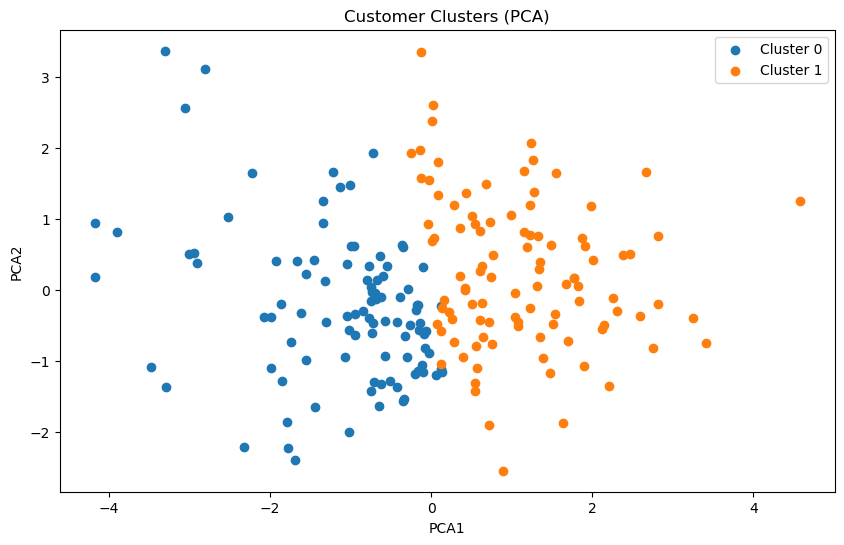

In [97]:
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
plt.title('Customer Clusters (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

## Cluster Distribution

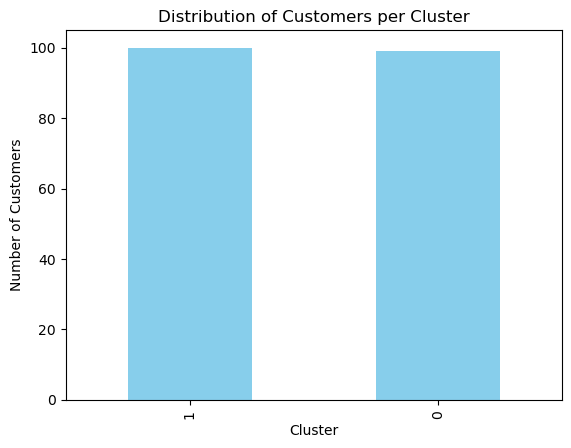

In [98]:
# Distribution of customers per cluster
customer_data['Cluster'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


# Results:

**Davies-Bouldin Index (DBI):**

A lower DBI score indicates well-separated clusters. Based on the code, the exact score will depend on the dataset used but should typically be below 1.0 for good clustering.

**Silhouette Score:**

This value ranges between -1 and 1:

Values close to 1 indicate well-separated clusters.

Values near 0 indicate overlapping clusters.

Negative values indicate incorrect clustering.

A Silhouette Score > 0.5 is considered decent.

**Cluster Distribution:**

The bar chart of customer distribution provides insights into the size of each cluster.

If one cluster dominates, it might suggest imbalance or the need for more clusters.